<a href="https://colab.research.google.com/github/Svetorus/Time-Series/blob/master/TS_3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.3)
import warnings 

from itertools import product

%matplotlib inline

## Загрузка временного ряда

In [0]:
pjme_df = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
pjme_df.sort_index(inplace=True)
pjme_df.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


### Месячный ресемплинг:

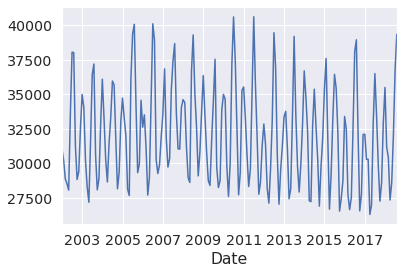

In [0]:
pjme_monthly = pjme_df['PJME_MW'].resample('M').mean()

pjme_monthly.plot()
plt.show()

По полученному ряду видно, что есть явные сезонные колебания.

### Загрузка статистических модулей и библиотек

In [0]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Разделение ряда на train и test
#### Отделим последний год:

In [0]:
test_pjme_monthly = pjme_monthly.tail(12)

pjme_monthly = pjme_monthly[:-12]

### Стационарность ряда и задание $d, D$
#### Исходный ряд:

In [0]:
adfuller(pjme_monthly, regression='ctt') # ‘ctt’ : constant, and linear and quadratic trend.

(-3.4301985917072786,
 0.13161273855976557,
 15,
 172,
 {'1%': -4.43977965973908,
  '5%': -3.8671708983800173,
  '10%': -3.574728149306036},
 3009.4236156621982)

Ряд не стационарен.


#### Сделаем сдвиг на 12 месяцев:

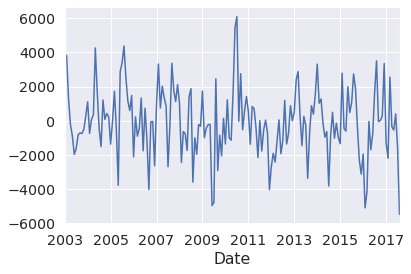

In [0]:
pjme_monthly_diff12 = pjme_monthly - pjme_monthly.shift(12)
pjme_monthly_diff12.dropna(inplace=True)
pjme_monthly_diff12.plot()
plt.show()

In [0]:
adfuller(pjme_monthly_diff12, regression='ctt') # ‘ctt’ : constant, and linear and quadratic trend.

(-4.87428265683081,
 0.0016731002828703964,
 12,
 163,
 {'1%': -4.443648535439729,
  '5%': -3.8691186976819476,
  '10%': -3.5759254270960645},
 2863.057164348892)

Ряд согласно критерию Дики-Фуллера стал стационарным, однако по графику ряда можно утверждать, что некоторая сезонность сохраняется. Кроме того, значение статистики близко к критичному по уровню значимости 1%.

#### Сделаем сдвиг на 1 месяц:

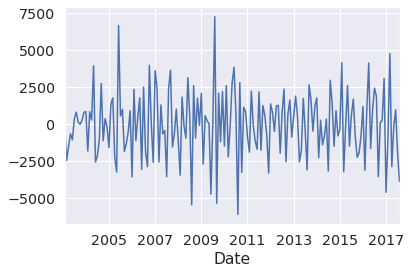

In [0]:
pjme_monthly_diff12_diff1 = pjme_monthly_diff12 - pjme_monthly_diff12.shift(1)
pjme_monthly_diff12_diff1.dropna(inplace=True)
pjme_monthly_diff12_diff1.plot()
plt.show()

In [0]:
adfuller(pjme_monthly_diff12_diff1, regression='ctt') # ‘ctt’ : constant, and linear and quadratic trend.

(-6.44303885080723,
 1.4506181673026267e-06,
 14,
 160,
 {'1%': -4.4450369841308595,
  '5%': -3.869817393554688,
  '10%': -3.576354775146484},
 2860.9121860379237)

Критерий cильнее отвергает нестационарность ряда. По графику ряд также вполне стационарен.

Таким образом, зададим параметры $d = 1$, $D = 1$.

### Определение максимальных границ для $p, P, q, Q$
#### Автокорреляционная функция:

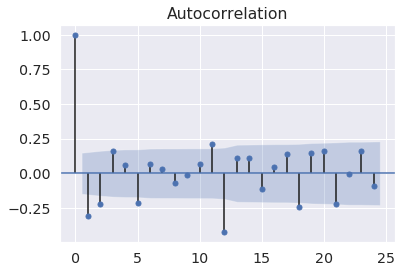

In [0]:
plot_acf(pjme_monthly_diff12_diff1, lags=24)
plt.show()

Пусть $Q = 1$ (есть значимый лаг $12$), $q = 5$.

#### Частичная автокорреляция:

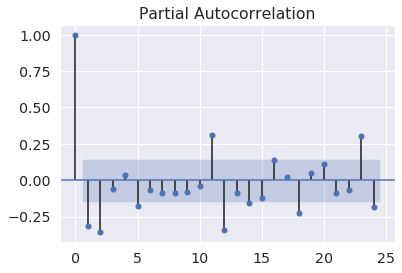

In [0]:
plot_pacf(pjme_monthly_diff12_diff1, lags=24)
plt.show()

Пусть $P = 1$ (есть значимый лаг $12$), $p = 5$.

### Поиск оптимальной модели SARIMAX
#### Набор параметров:

In [0]:
d, D = 1, 1
ps, Ps = np.arange(0, 6), np.arange(0, 2)
qs, Qs = np.arange(0, 6), np.arange(0, 2)

In [0]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

144

#### Перебор параметров:

In [0]:
%%time
results = []
opt_aic = float('inf')
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=SARIMAX(pjme_monthly, order=(param[0], d, param[1]), 
                      seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < opt_aic:
        opt_model = model
        opt_aic = aic
        opt_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 4min 55s, sys: 7.72 s, total: 5min 2s
Wall time: 3min 22s


Топ-5 моделей

In [0]:
result_table = pd.DataFrame(results, columns=['parameters', 'aic'])
result_table.sort_values(by='aic', ascending=True).head()

,parameters,aic
75,"(3, 0, 1, 1)",3137.576136
7,"(0, 1, 1, 1)",3137.757411
15,"(0, 3, 1, 1)",3137.829181
55,"(2, 1, 1, 1)",3137.957867
63,"(2, 3, 1, 1)",3138.341326


#### Лучшая модель:

In [0]:
print(opt_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            PJME_MW   No. Observations:                  188
Model:             SARIMAX(3, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -1562.788
Date:                            Mon, 09 Dec 2019   AIC                           3137.576
Time:                                    15:45:56   BIC                           3156.565
Sample:                                01-31-2002   HQIC                          3145.278
                                     - 08-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2372      0.050     -4.713      0.000      -0.336      -0.139
ar.L2         -0.1465      0.039   

### Анализ остатков

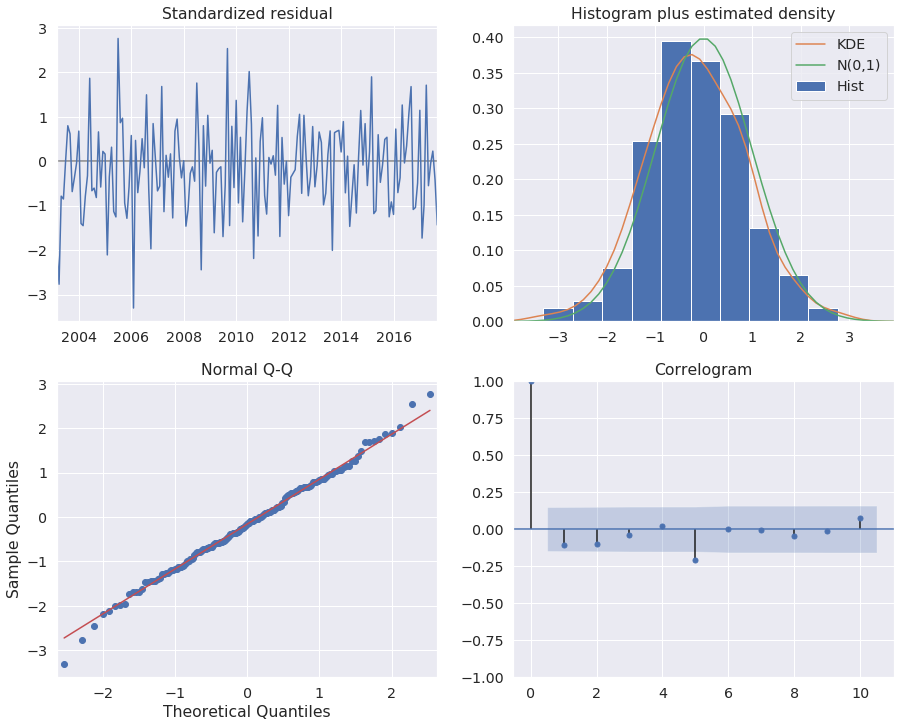

In [0]:
opt_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Распределение остатков близко к нормальному с нулевым матжиданием и единичной дисперсией.

In [0]:
adfuller(opt_model.resid)

(-5.383534499416409,
 3.6676316084743513e-06,
 4,
 183,
 {'1%': -3.466598080268425,
  '5%': -2.8774669520682674,
  '10%': -2.5752604356654425},
 3057.560762992398)

Согласно критерию Дики-Фуллера остатки стационарны.

#### Графики исходного ряда и предсказанного моделью (без начального участка обучения):

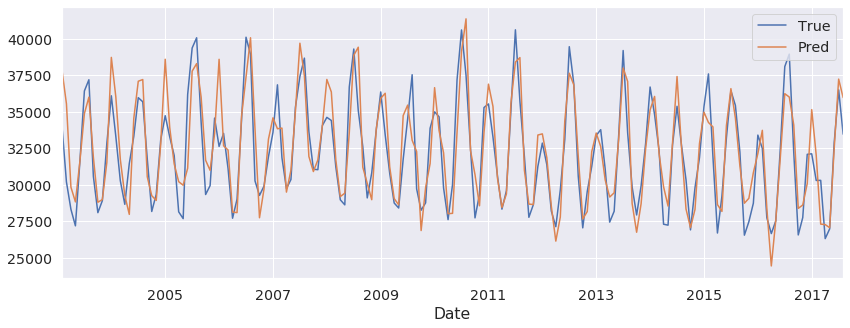

In [0]:
plt.figure(figsize=(14, 5))
pjme_monthly[13:].plot(label='True')
opt_model.fittedvalues[13:].plot(label='Pred')
plt.legend(loc='best')
plt.show()

### Прогноз
Проверим на тесте и соответствующих ему исходных данных:

In [0]:
last_values = pjme_df.loc[pjme_df['PJME_MW'].index > '2017-09-30', 'PJME_MW']

prediction = opt_model.predict(start=188, end=199)

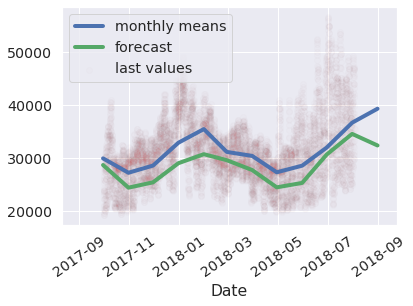

In [0]:
plt.scatter(last_values.index, last_values, label='last values', c='r', alpha=0.01)
plt.plot(test_pjme_monthly.index, test_pjme_monthly, lw=4, label='monthly means')
plt.plot(prediction.index, prediction, lw=4, label='forecast', c='g')
plt.xlabel('Date')
plt.xticks(rotation=35)
plt.legend(loc='best')
plt.show()

Прогноз вполне адекватен. Модель сохранила особенности исходного ряда, однако заметно некоторое смещение как относительно исходного ряда, так и его средних по месяцам. В качестве объяснения: возможно, это ухудшение качества предсказания из-за того, что модель обучалась на средних по месяцам, либо это ограничение полученной модели и ее нужно улучшать (работать с остатками, новые признаки и т.д.).